In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from scipy import stats
from numpy import mean

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
Measurement_columns = inspector.get_columns('Measurement')
Station_columns = inspector.get_columns('Station')
for c in Measurement_columns:
    print(c['name'], c["type"])
for c in Station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_day)
last_day_last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_day_last_year)

('2017-08-23',)
2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
One_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_day_last_year).all() 

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
One_year_prcp_df = pd.DataFrame(One_year_prcp, columns=['date', 'prcp'])
One_year_prcp_df.sort_values('date', inplace=True, ascending=True)
One_year_prcp_df.set_index('date', inplace=True)
One_year_prcp_df.dtypes
One_year_prcp_df

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


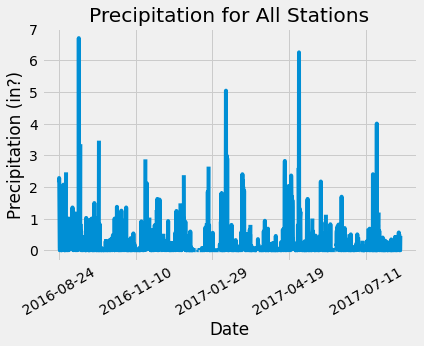

<Figure size 432x288 with 0 Axes>

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
#This plot doesn't really make sense (mixed stations), but seems to be what's asked for.
ax = One_year_prcp_df.plot(title="Precipitation for All Stations", rot=30, legend=False)
ax.set_ylabel("Precipitation (in?)")
ax.set_xlabel("Date")
plt.show()
plt.savefig("Precipitation_all_stations.png")

###Assorted questions

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
One_year_prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(stations)

#Double check:
#stations = session.query(Station.station).all()
#print(stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity =  session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).\
    all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
#Checking that maximum activity is at the same station for different observations
station_temp_activity =  session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    all()
station_temp_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Checking that maximum activity is at the same station for different observations
station_prcp_activity =  session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).\
    all()
station_prcp_activity

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#Thanks to Monica T. James of the internet for a quicker way of doing this! I think I will delete my ugly method.
busiest_station = station_prcp_activity[0][0]
busiest_station
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
              func.max(Measurement.tobs)).filter(Measurement.station == busiest_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [21]:
busiest_station_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > last_day_last_year).filter(Measurement.station==busiest_station).all() 
busiest_station_tobs

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
busiest_station_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > last_day_last_year).filter(Measurement.station==busiest_station).all() 
busiest_station_tobs
busiest_station_tobs_df = pd.DataFrame(busiest_station_tobs, columns=['date', 'tobs'])
busiest_station_tobs_df.sort_values('date', inplace=True, ascending=True)
busiest_station_tobs_df.set_index('date', inplace=True)
busiest_station_tobs_df

,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


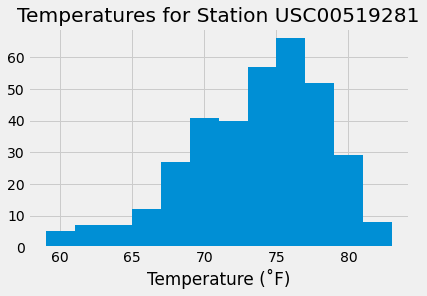

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot the results as a histogram
busiest_station_tobs_df.hist(bins=12)
plt.tight_layout()
plt.title(f"Temperatures for Station {busiest_station}")
plt.xlabel("Temperature (˚F)")
plt.show()
plt.savefig("Busiest_station_temps.png")

In [24]:
# Using the the station with the highest number of temperature (and prcp) observations:
# Query the last 12 months of prcp observation data for this station
busiest_station_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_day_last_year).filter(Measurement.station==busiest_station).all() 
busiest_station_prcp_df = pd.DataFrame(busiest_station_prcp, columns=['date', 'prcp'])
busiest_station_prcp_df.sort_values('date', inplace=True, ascending=True)
busiest_station_prcp_df.set_index('date', inplace=True)
busiest_station_prcp_df.dtypes
busiest_station_prcp_df

,prcp
date,
2016-08-24,2.15
2016-08-25,0.06
2016-08-26,0.01
2016-08-27,0.12
2016-08-28,0.60
...,...
2017-08-14,0.00
2017-08-15,0.32
2017-08-16,0.12


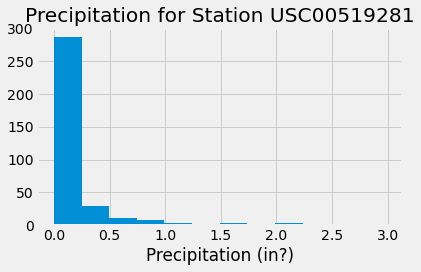

<Figure size 432x288 with 0 Axes>

In [25]:
# Plot the results as a histogram, just because
busiest_station_prcp_df.hist(bins=12)
plt.title(f"Precipitation for Station {busiest_station}")
plt.xlabel("Precipitation (in?)")
plt.tight_layout()
plt.show()
plt.savefig("Busiest_station_prcp.png")

##Temperature Analysis I

In [73]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.

#Read measurement file csv as dataframe
Measurement_df = pd.read_csv('Resources/hawaii_measurements.csv')
Measurement_df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


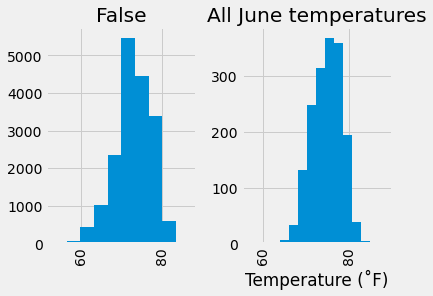

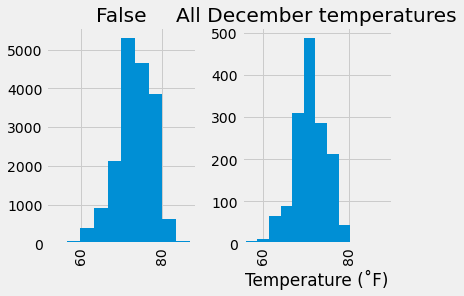

In [109]:
#Plot histograms for June and December temperatures
#Distributions do actually look a bit different.

#ax = Measurement_df['tobs'].hist(by=Measurement_df['date'].dt.month)

ax = Measurement_df['tobs'].hist(Measurement_df['date'].dt.month == 6)
plt.xlim(xmin=55, xmax = 90)
plt.xlabel("Temperature (˚F)")
plt.title(f"All June temperatures")
plt.savefig("June_temp_histogram_all_stations.png")
ax = Measurement_df['tobs'].hist(Measurement_df['date'].dt.month == 12)
plt.xlim(xmin=55, xmax = 90)
plt.xlabel("Temperature (˚F)")
plt.title(f"All December temperatures")
plt.savefig("December_temp_histogram_all_stations.png")

In [92]:
#Find mean temperatures for June and December
June_mean=Measurement_df[(Measurement_df['date'].dt.month == 6)]['tobs'].mean
December_mean=Measurement_df[(Measurement_df['date'].dt.month == 12)]['tobs'].mean
print(June_mean, December_mean)

#June mean 78, December mean 76

<bound method Series.mean of 133      78
134      76
135      78
136      76
137      77
         ..
19492    79
19493    74
19494    74
19495    76
19496    75
Name: tobs, Length: 1700, dtype: int64> <bound method Series.mean of 305      76
306      74
307      74
308      64
309      64
         ..
19323    71
19324    71
19325    69
19326    65
19327    65
Name: tobs, Length: 1517, dtype: int64>


Use the t-test to determine whether the difference in the means, if any, is statistically significant.

Will you use a paired t-test, or an unpaired t-test? Why?

Unpaired t-test, because the number of measurements differ by station and month.

In [95]:
#Shapiro-Wilk test for normality 

June_Shapiro_test = stats.shapiro(Measurement_df[(Measurement_df['date'].dt.month == 6)]['tobs'])
December_Shapiro_test = stats.shapiro(Measurement_df[(Measurement_df['date'].dt.month == 12)]['tobs'])
print(June_Shapiro_test, December_Shapiro_test)

#p-values << 0.05, reject the null hypothesis that data are normally distributed, so actually should not use t-test.

ShapiroResult(statistic=0.983282744884491, pvalue=3.5219510684594835e-13) ShapiroResult(statistic=0.9843476414680481, pvalue=9.044617485520767e-12)


In [97]:
#Using paired t-test anyway.
stats.ttest_ind(Measurement_df[(Measurement_df['date'].dt.month == 6)]['tobs'], Measurement_df[(Measurement_df['date'].dt.month == 12)]['tobs'])
#p-value << 0.05, can reject the null hypothesis that the means are equal.

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

## Temperature Analysis II

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d        
    Returns:
        TMIN, TAVE, and TMAX
    """    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#Huh? A) It's 2020, data ends in 2017; B) When did I pick trip dates? 
#Well, let's say I wanted to take a trip from September 15-22 in 2017, hoping for cyclones.

calc_temps('2016-09-15', '2016-09-22')

[(70.0, 77.23529411764706, 81.0)]

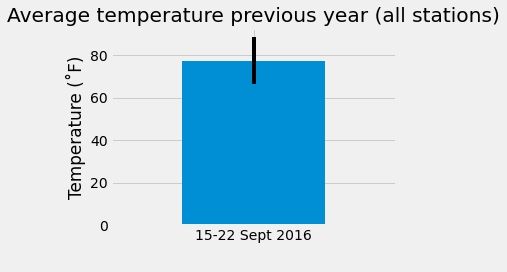

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

df = pd.DataFrame({' ':["15-22 Sept 2016"], 'val':[77.23529411764706]})
ax = df.plot.bar(x=' ', y='val', yerr=(81.0-70.0), rot=0, legend=False)

plt.title(f"Average temperature previous year (all stations)")
plt.ylabel("Temperature (˚F)")
plt.tight_layout()
plt.show()
plt.savefig("Average_temp_last_year.png")

#That is one bogus error bar.

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [43]:
#Combine Measurement and Station files as single dataframe
Measurement_df = pd.read_csv('Resources/hawaii_measurements.csv')
Station_df = pd.read_csv('Resources/hawaii_stations.csv')
combined_data_df = pd.merge(Measurement_df, Station_df, on="station", how="inner")
combined_data_df

,station,date,prcp,tobs,name,latitude,longitude,elevation
0,USC00519397,2010-01-01,0.08,65,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,USC00519397,2010-01-02,0.00,63,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
2,USC00519397,2010-01-03,0.00,74,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
3,USC00519397,2010-01-04,0.00,76,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
4,USC00519397,2010-01-06,NaN,73,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
...,...,...,...,...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19546,USC00516128,2017-08-20,NaN,78,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19547,USC00516128,2017-08-21,0.56,76,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4
19548,USC00516128,2017-08-22,0.50,76,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4


In [44]:
#Select data for trip dates
trip_dates_df = combined_data_df[(combined_data_df['date']>='2016-09-15') & (combined_data_df['date']<='2016-09-22')]
trip_dates_df

,station,date,prcp,tobs,name,latitude,longitude,elevation
2386,USC00519397,2016-09-15,0.42,79,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2387,USC00519397,2016-09-16,0.06,80,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2388,USC00519397,2016-09-17,0.05,79,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2389,USC00519397,2016-09-18,0.00,81,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2390,USC00519397,2016-09-19,0.00,77,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2391,USC00519397,2016-09-20,0.00,77,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2392,USC00519397,2016-09-21,0.00,78,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2393,USC00519397,2016-09-22,0.02,76,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5113,USC00513117,2016-09-15,0.12,78,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5114,USC00513117,2016-09-16,0.01,78,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6


In [72]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
last_year_rain = trip_dates_df.groupby(['station','name','latitude','longitude','elevation'])[['prcp']].agg('sum')
last_year_rain.sort_values(by='prcp', ascending=False)

,,,,,prcp
station,name,latitude,longitude,elevation,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.06
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.96
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.58
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.55
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.42
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.32
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.06


In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
#normals = []


#09-15
#09-22
daily_normals("09-15")

[(67.0, 76.14, 81.0)]

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
